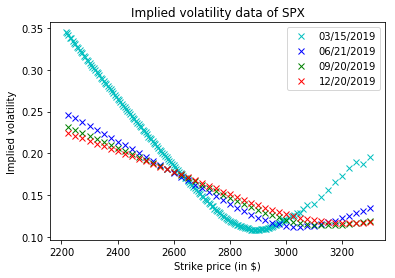

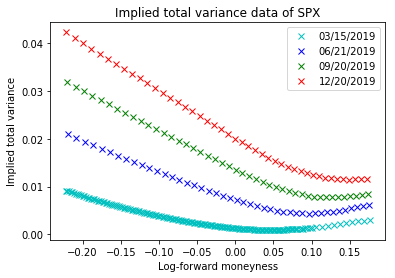

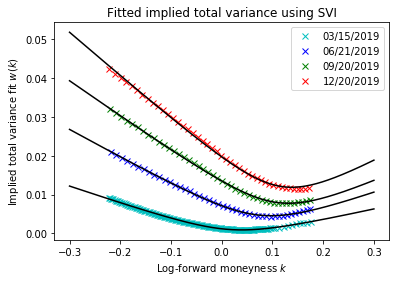

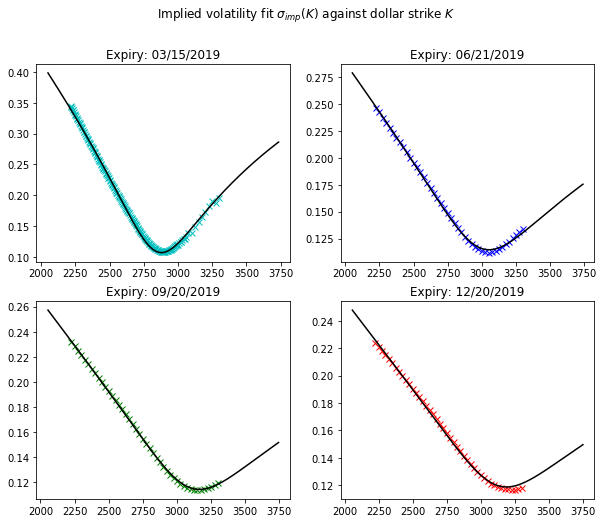

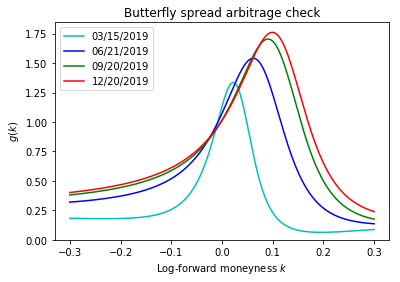

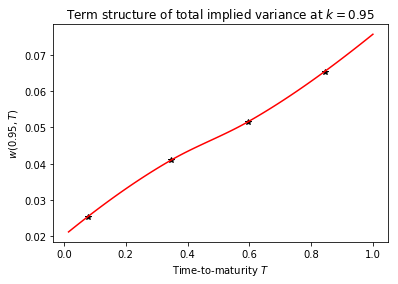

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator

def SVI(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m) **2 + sigma **2))

def butterflyG(k, a, b, rho, m, sigma):
    
    w = SVI(k, a, b, rho, m, sigma)
    dw = b * (rho + (k - m) / np.sqrt((k - m) **2 + sigma **2))
    ddw = b * (np.sqrt((k - m) **2 + sigma **2) - (k - m)**2 / np.sqrt((k - m) **2 + sigma **2)) / ((k - m)**2 + sigma**2)
    
    return (1 - k * dw / (2 * w)) ** 2 - 0.25 * (0.25 + 1/ w) * dw ** 2 + 0.5 * ddw
    
spot = 2765.5       # Spot level of SPX
r = 0.025           # Interest rate used for forward calculation
div = 0.02          # Dividend yield used for forward calculation

merged_df  = pd.read_csv("SPXDataSmall.csv")        # Laod the data file
listed_expiry = merged_df.expiration_date.unique()  # Read all the expiration dates (in string format)

today = "02/15/2019"            # Today (valuation date of option) in string
date_format = '%m/%d/%Y'        # Quotation format of date in our raw data

# Work out the maturity of each expiration date in unit of years and store the values in array T
T = []
for expiry in listed_expiry:
    T.append((dt.datetime.strptime(expiry, date_format) - dt.datetime.strptime(today, date_format)).days / 365) 

# Obtain the forward price of SPX for each maturity
fwd = spot * np.exp((r - div)* np.asarray(T))

# Introduce some color schemes for plotting
colorcode = ['cx', 'bx', 'gx', 'rx', 'mx', 'yx', 'kx']
colorline = ['c-', 'b-', 'g-', 'r-', 'm-', 'y-', 'k-']

# Plot the implied volatility surface and total variance surface for each expiry
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for i, expiry in enumerate(listed_expiry):
    tempdf = merged_df[merged_df['expiration_date'] == expiry] 
    ax1.plot(tempdf.strike, tempdf.iv, colorcode[i], label = expiry)  
    ax2.plot(np.log(tempdf.strike / fwd[i]), tempdf.iv**2 * T[i], colorcode[i], label = expiry) 

ax1.legend()
ax1.set_ylabel('Implied volatility')
ax1.set_xlabel('Strike price (in $)')
ax1.set_title('Implied volatility data of SPX')
#fig.savefig('ivol', dpi = 600)

ax2.legend()
ax2.set_ylabel('Implied total variance')
ax2.set_xlabel('Log-forward moneyness')
ax2.set_title('Implied total variance data of SPX')
#fig2.savefig('ivar', dpi = 600)

# Set up initial guess for SVI parameters estimation. May need to try different initial guesses for good results
x0 = [-0.002, 0.04, -0.2, 0.02, 0.1]

# Set up the bounds on each parameter
bnd0 = (-np.inf, np.inf)
bnd1 = (0, np.inf)
bnd2 = (-1, 1)
bnd3 = (-np.inf, np.inf)
bnd4 = (0, np.inf)
bnds = (bnd0, bnd1, bnd2, bnd3, bnd4)

fitpara = np.zeros((len(T), 5))

fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots(2, 2, figsize=(10, 8))
fig5, ax5 = plt.subplots()

# Range of log-forward moneyness used for plotting the SVI fit
svi_k = np.linspace(-0.3, 0.3, 1000)

# Solve the optimal SVI parameters for each maturity slice
for i, expiry in enumerate(listed_expiry):
    
    tempdf = merged_df[merged_df['expiration_date'] == expiry]
    y = tempdf.iv**2 * T[i]
    k = np.log(tempdf.strike /fwd[i])
    
    # Call the solver: minimise the sum of squared diff between fitted and market total implied variance
    solution = minimize(lambda x: np.sum((SVI(k, x[0], x[1], x[2], x[3], x[4]) - y) ** 2), x0, method='SLSQP', bounds=bnds)
    fitpara[i,:] = solution.x
    x0 = solution.x   # update the initial guess for the optimisation of the next expiry using the current expiry's parameters 
    
    # Plot the fitted implied total variance surface together with the market data
    ax3.plot(k, y, colorcode[i],label=expiry)
    ax3.plot(svi_k, SVI(svi_k, fitpara[i, 0], fitpara[i, 1], fitpara[i, 2], fitpara[i, 3], fitpara[i, 4]), 'k-')
    
    # Plot individually the fitted implied volatility curve with market data
    ax4[int(i / 2), i % 2].plot(tempdf.strike, tempdf.iv, colorcode[i])
    ax4[int(i / 2), i % 2].plot(np.exp(svi_k) * fwd[i], np.sqrt(SVI(svi_k, fitpara[i, 0], fitpara[i, 1], fitpara[i, 2], fitpara[i, 3], fitpara[i, 4])/T[i]), 'k-')
    ax4[int(i / 2), i % 2].set_title('Expiry: '+ expiry)
    
    # Plot the butterfly check function
    ax5.plot(svi_k, butterflyG(svi_k, fitpara[i, 0], fitpara[i, 1], fitpara[i, 2], fitpara[i, 3], fitpara[i, 4]), colorline[i], label=expiry)
    

# Labelling of plots
ax3.set_ylabel('Implied total variance fit $w(k)$')
ax3.set_xlabel('Log-forward moneyness $k$')
ax3.set_title('Fitted implied total variance using SVI')
ax3.legend()
#fig3.savefig('fitivar', dpi = 600)

fig4.suptitle("Implied volatility fit $\sigma_{imp}(K)$ against dollar strike $K$")
#fig4.savefig('fitivol', dpi = 600)

ax5.set_ylabel('$g(k)$')
ax5.set_xlabel('Log-forward moneyness $k$')
ax5.set_title('Butterfly spread arbitrage check')
ax5.set_ylim([0,None])
ax5.legend()
#fig5.savefig('svibutterfly', dpi = 600)

# Plot the term structure of total implied variance at one fixed strike and apply monotonic interpolation
fig6, ax6 = plt.subplots()
varts = SVI(0.95, fitpara[:,0], fitpara[:,1], fitpara[:,2], fitpara[:,3], fitpara[:,4])
atmvarIP = PchipInterpolator(T, varts) # Interpolation object
t = np.linspace(0.015, 1, 100)
ax6.plot(T, varts, 'k*')
ax6.plot(t, (PchipInterpolator(T, varts))(t), 'r-')

# Labelling
ax6.set_ylabel('$w(0.95,T)$')
ax6.set_xlabel('Time-to-maturity $T$')
ax6.set_title('Term structure of total implied variance at $k=0.95$')
fig6.savefig('tsvar', dpi = 600)